In [1]:
import pandas as pd #데이터 처리를 위한 pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler #모델 평가를 위한 scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import time
import itertools
import os
import gc
import pickle
from xgboost import XGBRegressor #모델 구축을 위한 XGBoost
from xgboost import plot_importance
from matplotlib import rcParams #시각화를 위한 matplotlib

# 그림 크기 설정: matplotlib의 그림 크기를 설정합니다.
rcParams['figure.figsize'] = 12, 4 

In [2]:
#데이터 불러오기
try:
    test = pd.read_csv('Data/test.csv', encoding='utf-8')
    train = pd.read_csv('Data/train.csv', encoding='utf-8')
except UnicodeDecodeError:
    #UTF-8로 실패한 경우 CP949로 재시도
    test = pd.read_csv('Data/test.csv', encoding='cp949')
    train = pd.read_csv('Data/train.csv', encoding='cp949')    

### Data Preprocessing

In [3]:
train['address'] = train['location'] + ' ' + train['street']

In [4]:
train['type'].value_counts()
# 방의 타입에 따른 방개수 생성
# EXECUTIVE, MULTI-GENERATION는 결측치로 변경
tmp = []
for i in train['type']:
    if i == '5 ROOM':
        tmp.append(5)
    elif i == '4 ROOM':
        tmp.append(4)
    elif i == '3 ROOM':
        tmp.append(3)
    elif i == '2 ROOM':
        tmp.append(2)
    elif i == '1 ROOM':
        tmp.append(1)
    elif i == 'EXECUTIVE':
        tmp.append(None)
    else :
        tmp.append(None)
    
train['type_num'] = tmp

# 방개수 결측치 중앙값으로 -> execute 값을 none 값으로 했는데 그걸 median()메서드를 사용하여 전체 값의 중앙값으로 설정해줌
tmp = []

tmp = train['type_num'].fillna(train['type_num'].median())
train['type_num'] = tmp
train['type_num']

# 결측치 확인
train['type_num'].isna().sum()

0

In [5]:
# 방개수에 따른 방하나 평균 면적(m^2)
tmp = []
for num_rooms, area_sqm in zip(train['type_num'], train['area_sqm']):
    tmp.append(round(area_sqm/num_rooms, 3))
train['area_per_room'] = tmp

In [6]:
# 단위면적(1m^2)당 가격
#tmp = []
#for price, area in zip(train['price'], train['area_sqm']):
#    tmp.append( round(price/area, 3) )
#train['price_per_unitarea'] = tmp

In [7]:
# 방개수에 따른 방하나 평균 가격 --> 0으로 나와서 지우겠음.
#tmp = []
#for price, num_rooms in zip(train['price'], train['type_num']):
#    tmp.append( round(num_rooms/price, 3) )
#train['price_per_room'] = tmp

In [8]:
# 'date' 컬럼을 datetime 타입으로 변환하고, 연, 월 로 분리
tmp = {}
tmp['date'] = pd.to_datetime(train['date'])
train['Year'] = tmp['date'].dt.year
train['Month'] = tmp['date'].dt.month
train.drop('date', axis = 1, inplace = True)

In [9]:
#팔리기까지의 기간
tmp_list = []

for i, j in zip(train['commence_date'], train['Year']):
    tmp_list.append(j-i)

train['time_to_sell'] = tmp_list

In [10]:
#  2000~2012년의 미국 금리 데이터를 가져옴
interest_rate_df = pd.read_csv('Data/interest_rate.csv')
interest_rate_df

,interest_rate_date,interest_rate
0,2012-12-13,0.25
1,2012-10-25,0.25
2,2012-09-14,0.25
3,2012-08-02,0.25
4,2012-06-21,0.25
...,...,...
73,2001-02-01,5.50
74,2001-01-04,6.00
75,2000-05-17,6.50
76,2000-03-22,6.00


In [11]:
# 날자 데이터를 비교하여 당일의 금리를 확인하여 저장

tmp = interest_rate_df['interest_rate'][77]
tmp_interest_rate = []

for year, month in zip(train['Year'], train['Month']):
    date = str(year) + '-' + str(month)
    # print(pd.Timestamp(date))
    
    for interest_date, interest_rate in zip(interest_rate_df['interest_rate_date'][::-1], interest_rate_df['interest_rate'][::-1]):
        if pd.Timestamp(date) < pd.Timestamp(interest_date):
            # 금리 갱신일 이 날자보다 커지면 그 이전 날의 금리(tmp)를 저장
            tmp_interest_rate.append(tmp)
            tmp = interest_rate_df['interest_rate'][77]
            break
        # 금리 갱신일이 당일 날자보다 낮다면 해당의 금리로 tmp를 갱신
        tmp = interest_rate

In [12]:
# 생성한 리스트를 dataframe에 합침
train['interest_rate'] = tmp_interest_rate

In [13]:
#라벨 인코딩: 모델이 이해하기 쉽도록 범주형 데이터를 숫자로 분류하여 줌
train['address_code'] = LabelEncoder().fit_transform(train['address'])

categorial_features = ['block', 'storey_range', 'flat_model']
numerical_features = ['area_sqm']

le = LabelEncoder()
for i in categorial_features:
    train[i] = le.fit_transform(train[i])

scaler = MinMaxScaler()
train[numerical_features] = scaler.fit_transform(train[numerical_features])

In [14]:
#라벨 인코딩 후 Object(문자열) 컬럼들을 제거 함.
train = train.drop(['address', 'location', 'street', 'type'], axis = 1)

In [15]:
train

,house_id,block,storey_range,area_sqm,flat_model,commence_date,price,type_num,area_per_room,Year,Month,time_to_sell,interest_rate,address_code
0,199577,34,2,0.325397,3,2003,313000.0,5.0,22.000,2006,9,3,5.25,346
1,217021,1445,2,0.142857,13,1988,167000.0,3.0,21.333,2007,6,19,5.25,131
2,308062,1092,3,0.253968,10,1976,430000.0,4.0,23.000,2010,9,34,0.25,458
3,212465,742,3,0.253968,10,1977,303800.0,4.0,23.000,2007,4,30,5.25,62
4,60654,1662,1,0.293651,6,1998,212000.0,4.0,25.500,2001,10,3,3.00,153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271716,101563,1004,1,0.297619,6,1989,232000.0,4.0,25.750,2003,1,14,1.25,315
271717,28297,1257,3,0.420635,6,1996,428000.0,5.0,26.800,2000,11,4,6.50,300
271718,321995,853,4,0.357143,3,2004,548888.0,5.0,23.600,2011,4,7,0.25,78
271719,308162,1936,4,0.246032,8,1999,360000.0,4.0,22.500,2010,9,11,0.25,136


In [16]:
X = train.drop('price', axis = 1)
y = train['price']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

c:\Users\cchok\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\cchok\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\cchok\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\cchok\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated 

    n_estimators     train_mae      test_mae  train_r2   test_r2      time
0            100  10933.977114  12467.493688  0.982559  0.975449  2.186116
1            200   9414.562599  11627.743968  0.987092  0.978285  3.458047
2            400   7956.180345  11395.334378  0.990811  0.978954  6.650408
3            500   7912.118126  11392.162418  0.990914  0.978961  7.055779
4            600   7912.118126  11392.162418  0.990914  0.978961  7.186636
5            700   7912.118126  11392.162418  0.990914  0.978961  7.214108
6            800   7912.118126  11392.162418  0.990914  0.978961  7.249400
7            900   7912.118126  11392.162418  0.990914  0.978961  7.906529
8           1000   7912.118126  11392.162418  0.990914  0.978961  7.945999
9           1500   7912.118126  11392.162418  0.990914  0.978961  7.951829
10          2000   7912.118126  11392.162418  0.990914  0.978961  8.430018


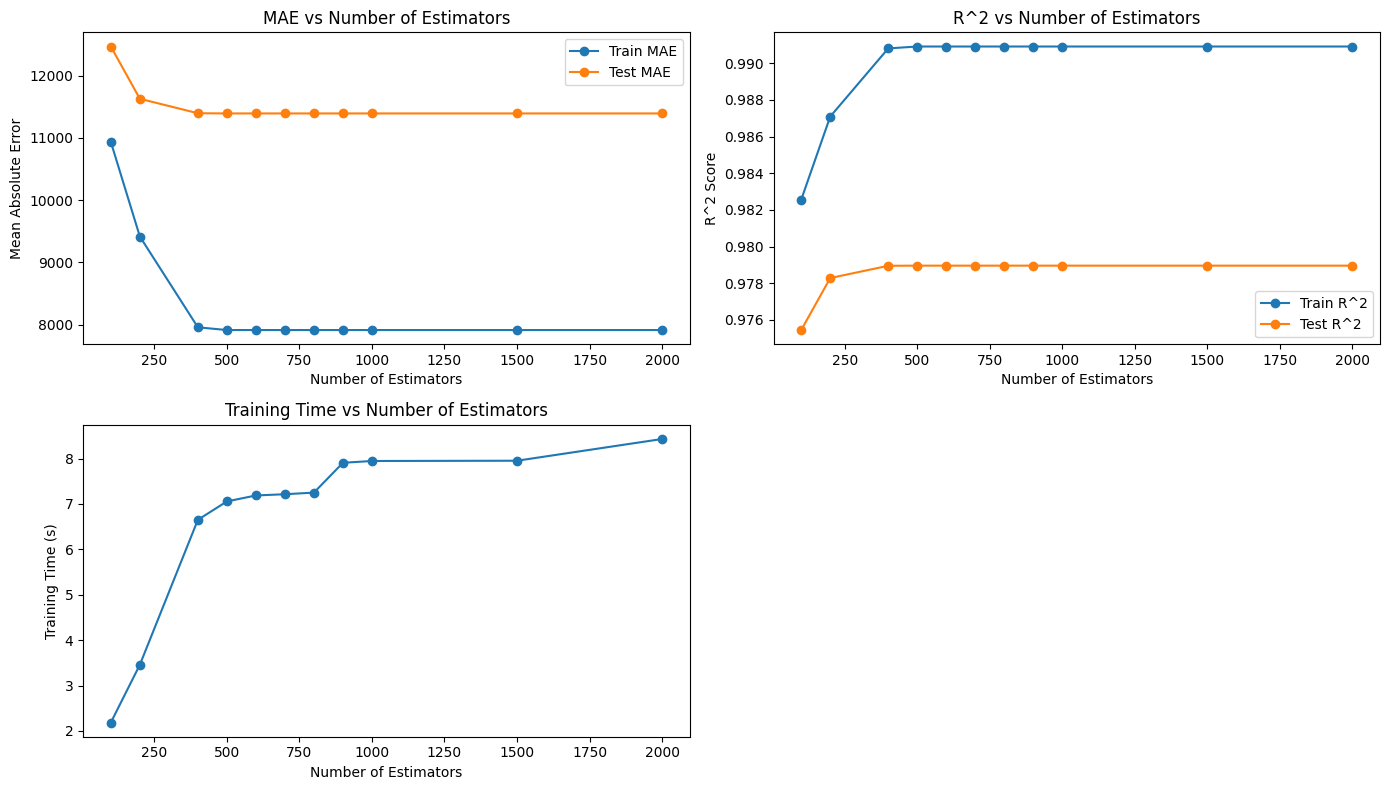

In [18]:
#다양한 n_estimators 값을 사용하여 모델을 학습하고, 각각의 성능을 평가하여 결과를 저장하고 시각화
n_estimators_list = [100, 200, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000]
results = []
learned_models = []

for n_estimators in n_estimators_list:
    model = XGBRegressor(
        max_depth=10,
        n_estimators=n_estimators,
        min_child_weight=0.5,
        colsample_bytree=0.8,
        subsample=0.8,
        eta=0.1,
        seed=77
    )
    
    ts = time.time()
    
    model.fit(
        X_train,
        y_train,
        eval_metric="rmse",
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False,
        early_stopping_rounds=20
    )
    
    elapsed_time = time.time() - ts
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    results.append({
        'n_estimators': n_estimators,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'time': elapsed_time
    })
    
    learned_models.append(model)

# 결과 출력
results_df = pd.DataFrame(results)
print(results_df)

# 결과 시각화
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.plot(results_df['n_estimators'], results_df['train_mae'], marker='o', label='Train MAE')
plt.plot(results_df['n_estimators'], results_df['test_mae'], marker='o', label='Test MAE')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Absolute Error')
plt.title('MAE vs Number of Estimators')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(results_df['n_estimators'], results_df['train_r2'], marker='o', label='Train R^2')
plt.plot(results_df['n_estimators'], results_df['test_r2'], marker='o', label='Test R^2')
plt.xlabel('Number of Estimators')
plt.ylabel('R^2 Score')
plt.title('R^2 vs Number of Estimators')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(results_df['n_estimators'], results_df['time'], marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Training Time (s)')
plt.title('Training Time vs Number of Estimators')

plt.tight_layout()
plt.show()

In [19]:
sub = pd.DataFrame({
    "house_id" : X_train.index,
    "price":y_pred_train
})

sub.to_csv('override_xgb_sub.csv', index = False)

pickle.dump(y_pred_train, open('Data/xgb_train.pickle','wb'))
pickle.dump(y_pred_test, open('Data/xgb_test.pickle','wb'))

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

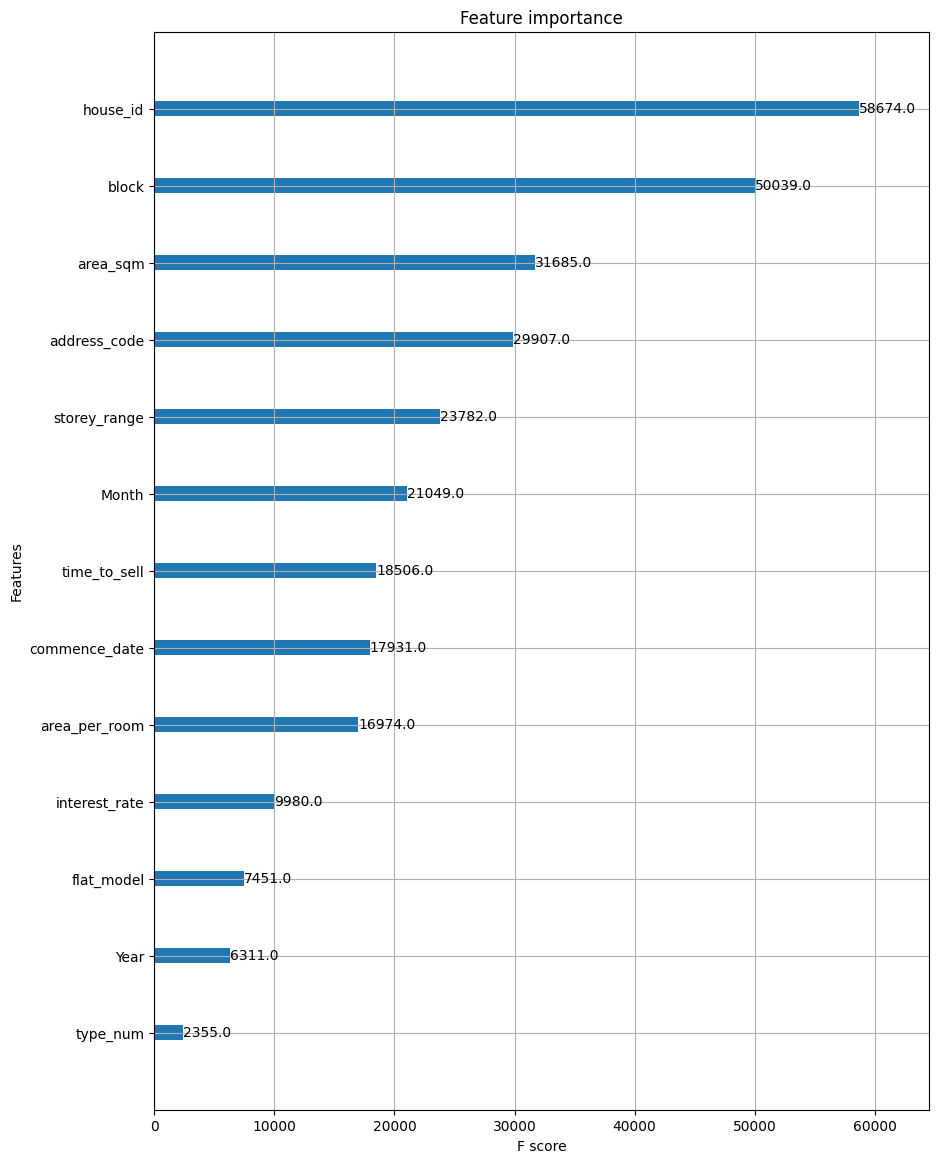

In [20]:
def plot_features(booster, figsize):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

In [21]:
# 교차 검증 수행 (5-Fold 교차 검증), 성능 지표로 MAE를 사용하며, cross_val_score는 기본적으로 점수가 클수록 좋다고 가정하므로 MAE의 음수 값을 사용합니다. 이는 MAE 값을 최대화하는 대신 최소화하기 위함입니다.
cv_scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'neg_mean_absolute_error')

print(cv_scores)

# MAE의 음수 값을 반환하므로, 이를 양수로 변환하여 해석
mae_scores = -cv_scores

print("교차 검증 MAE 점수:", mae_scores)
print("평균 MAE:", mae_scores.mean())
print("표준 편차:", mae_scores.std())

[-12152.61915717 -12181.04448335 -12173.76192384 -12089.24234117
 -12156.3782772 ]
교차 검증 MAE 점수: [12152.61915717 12181.04448335 12173.76192384 12089.24234117
 12156.3782772 ]
평균 MAE: 12150.609236545712
표준 편차: 32.45171377911602


In [22]:
### n_estimators=2000인 모델)을 다시 평가
# 모델 훈련 및 예측
model.fit(X_train, y_train) #이 코드 블록은 첫 번째 코드 블록의 마지막 n_estimators 값(2000)으로 모델을 학습시키고, 최종 성능을 평가
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# 평가 지표 계산
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f'Train MAE: {train_mae}, Train R^2: {train_r2}')
print(f'Test MAE: {test_mae}, Test R^2: {test_r2}')

Train MAE: 3545.2218508763326, Train R^2: 0.9980070912332223
Test MAE: 11934.007362465787, Test R^2: 0.9770747215424982


### 점수가 다른 이유
- 점수가 다른 이유는 두 코드 블록에서 평가하는 모델이 다르기 때문입니다. 
- 첫 번째 코드 블록에서는 다양한 n_estimators 값을 사용하여 여러 모델을 학습하고 평가하는 반면, 두 번째 코드 블록에서는 마지막으로 학습된 모델 (즉, n_estimators=2000인 모델)을 다시 평가합니다.

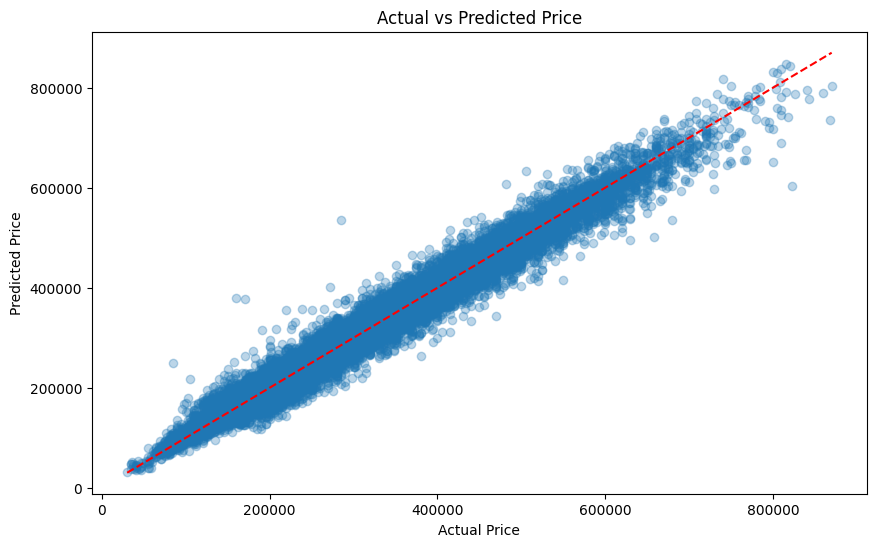

In [23]:
# 실제 값 vs 예측 값 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.show()